<a href="https://colab.research.google.com/github/Formula-Electric-Berkeley/FEBSim/blob/main/GGV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

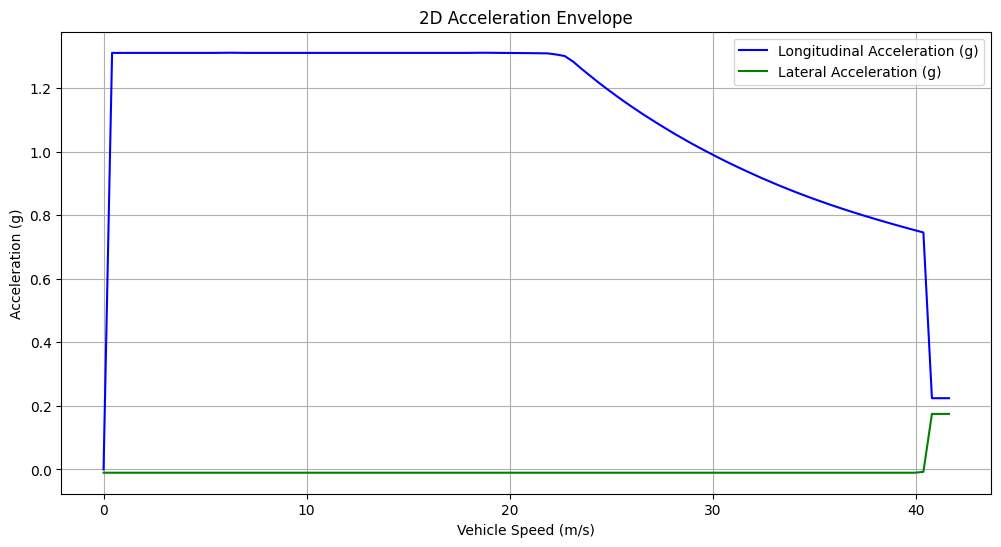

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Constants
vehicle_mass_kg = 241  # Vehicle mass in kg
g = 9.81  # Acceleration due to gravity in m/s^2
tire_radius_m = 0.2629  # Tire radius in meters for Hoosier R25B 20.5 x 7.0-13
gear_ratio = 3.54  # Gear ratio from your Python code

# Load the datasets
tire_data = pd.read_csv('B1320run125.csv', skiprows=[1])
motor_data = pd.read_csv('MotorPower.csv')

# Create interpolation functions for torque and power
torque_interp = interp1d(motor_data['Motor Speed (RPM)'], motor_data['Torque (Capped at 80kW) (Nm)'],
                         bounds_error=False, fill_value="extrapolate")
power_interp = interp1d(motor_data['Motor Speed (RPM)'],
                        motor_data['Torque (Capped at 80kW) (Nm)'] * motor_data['Motor Speed (RPM)'] * 2 * np.pi / 60,
                        bounds_error=False, fill_value="extrapolate")

# Prepare arrays to hold acceleration values
speed_range = np.linspace(0, tire_data['V'].max(), 100)  # Speed range from tire data
long_acc = np.zeros_like(speed_range)
lat_acc = np.zeros_like(speed_range)

# Calculate the traction force available at each speed point
for i, speed in enumerate(speed_range):
    engine_rpm = speed / (2 * np.pi * tire_radius_m) * 60 * gear_ratio
    if engine_rpm >= motor_data['Motor Speed (RPM)'].min() and engine_rpm <= motor_data['Motor Speed (RPM)'].max():
        engine_torque = torque_interp(engine_rpm)
        wheel_torque = engine_torque * gear_ratio
        traction_force = wheel_torque / tire_radius_m
        long_acc[i] = traction_force / vehicle_mass_kg / g

    # Interpolating lateral force data
    lat_force = np.interp(speed, tire_data['V'], tire_data['FY'])
    lat_acc[i] = lat_force / vehicle_mass_kg / g

# Normalize long_acc within the bounds of tire data
max_long_force = np.interp(speed_range, tire_data['V'], tire_data['FX'])
max_long_acc = max_long_force / vehicle_mass_kg / g
long_acc = np.clip(long_acc, -max_long_acc, max_long_acc)

# 2D plot for lateral and longitudinal acceleration
plt.figure(figsize=(12, 6))
plt.plot(speed_range, long_acc, label='Longitudinal Acceleration (g)', color='blue')
plt.plot(speed_range, lat_acc, label='Lateral Acceleration (g)', color='green')
plt.title('2D Acceleration Envelope')
plt.xlabel('Vehicle Speed (m/s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
from mpl_toolkits.mplot3d import Axes3D





# Your existing code to calculate long_acc and lat_acc here...

# Create meshgrid for 3D plot
speed_mesh, lat_acc_mesh = np.meshgrid(speed_range, lat_acc)
_, long_acc_mesh = np.meshgrid(speed_range, long_acc)

# Since we only have a single line for lateral and longitudinal acceleration, we need to expand it
# to create a surface. Here we assume that the lateral and longitudinal acceleration are independent.
# This might not be realistic as in real scenarios, they are often dependent on each other and you
# would need actual combined data points for correct visualization.

# For visualization purposes, we just repeat the lat_acc and long_acc arrays
lat_acc_expanded = np.tile(lat_acc, (len(speed_range), 1)).T
long_acc_expanded = np.tile(long_acc, (len(lat_acc), 1))

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(speed_mesh, lat_acc_expanded, long_acc_expanded, cmap='viridis')

# Add labels and title
ax.set_xlabel('Vehicle Speed (m/s)')
ax.set_ylabel('Lateral Acceleration (g)')
ax.set_zlabel('Longitudinal Acceleration (g)')
ax.set_title('GGV')

# Add color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


NameError: name 'pd' is not defined

In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit


data = pd.read_csv('B1320run54.csv', skiprows=[1])

def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def get_max_grip_by_velocity(data, load_bin):
    max_grip_by_velocity = {}
    lower_bound, upper_bound = load_bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    grouped = load_data.groupby('V')

    for velocity, group in grouped:
        x_data = group['SA']
        y_data = group['FY']

        # Ensure there are enough data points for fitting
        if len(x_data) <= 5:  # Number of parameters in the model + 1
            print(f"Not enough data points for velocity {velocity}.")
            continue

        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        try:
            optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
            x_model = np.linspace(x_data.min(), x_data.max(), 500)
            y_model = pacejka_model(x_model, *optimal_parameters)
            max_grip = max(y_model)
            max_grip_by_velocity[velocity] = max_grip
        except RuntimeError as e:
            print(f"Curve fitting failed for velocity {velocity} with error: {e}")

    return max_grip_by_velocity


# Example usage, assuming 'data' is your DataFrame loaded and preprocessed
load_bin = [-800, -400]
max_grip_results = get_max_grip_by_velocity(data, load_bin)
print(max_grip_results)


Not enough data points for velocity 39.46.
Not enough data points for velocity 39.47.
Not enough data points for velocity 39.49.
Not enough data points for velocity 39.5.
Not enough data points for velocity 39.51.
Not enough data points for velocity 39.52.
Not enough data points for velocity 39.53.
Not enough data points for velocity 39.55.
Not enough data points for velocity 39.56.
Not enough data points for velocity 39.57.
Not enough data points for velocity 39.59.
Not enough data points for velocity 39.62.
Not enough data points for velocity 39.63.
Not enough data points for velocity 39.65.
Not enough data points for velocity 39.66.
Not enough data points for velocity 39.67.
Not enough data points for velocity 39.68.
Not enough data points for velocity 39.69.
Not enough data points for velocity 39.7.
Not enough data points for velocity 39.71.
Not enough data points for velocity 39.72.
Not enough data points for velocity 39.73.
Not enough data points for velocity 39.75.
Not enough da

In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit


data = pd.read_csv('B1320run125.csv', skiprows=[1])

def pacejka_model(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def get_max_grip_by_velocity_long(data, load_bin):
    max_grip_by_velocity = {}
    lower_bound, upper_bound = load_bin
    load_data = data[(data['FZ'] >= lower_bound) & (data['FZ'] < upper_bound)]

    if load_data.empty:
        print(f"No data available for load bin {load_bin}.")
        return None

    grouped = load_data.groupby('V')

    for velocity, group in grouped:
        x_data = group['SR']
        y_data = group['FX']

        # Ensure there are enough data points for fitting
        if len(x_data) <= 5:  # Number of parameters in the model + 1
            print(f"Not enough data points for velocity {velocity}.")
            continue

        initial_guess = [0.5, 1.2, max(y_data), 1, 0]
        try:
            optimal_parameters, covariance = curve_fit(pacejka_model, x_data, y_data, p0=initial_guess, maxfev=15000)
            x_model = np.linspace(x_data.min(), x_data.max(), 500)
            y_model = pacejka_model(x_model, *optimal_parameters)
            max_grip = max(y_model)
            max_grip_by_velocity[velocity] = max_grip
        except RuntimeError as e:
            print(f"Curve fitting failed for velocity {velocity} with error: {e}")

    return max_grip_by_velocity


# Example usage, assuming 'data' is your DataFrame loaded and preprocessed
load_bin = [-800, -400]
max_grip_results_long = get_max_grip_by_velocity_long(data, load_bin)
print(max_grip_results)


Not enough data points for velocity 39.33.
Not enough data points for velocity 39.35.
Not enough data points for velocity 39.36.
Not enough data points for velocity 39.39.
Not enough data points for velocity 39.4.
Not enough data points for velocity 39.43.
Not enough data points for velocity 39.44.
Not enough data points for velocity 39.47.
Not enough data points for velocity 39.5.
Not enough data points for velocity 39.51.
Not enough data points for velocity 39.52.
Not enough data points for velocity 39.53.
Not enough data points for velocity 39.55.
Not enough data points for velocity 39.56.
Not enough data points for velocity 39.57.
Not enough data points for velocity 39.58.
Not enough data points for velocity 39.59.
Not enough data points for velocity 39.6.
Not enough data points for velocity 39.61.
Not enough data points for velocity 39.62.
Not enough data points for velocity 39.63.
Not enough data points for velocity 39.64.
Not enough data points for velocity 39.65.
Not enough dat

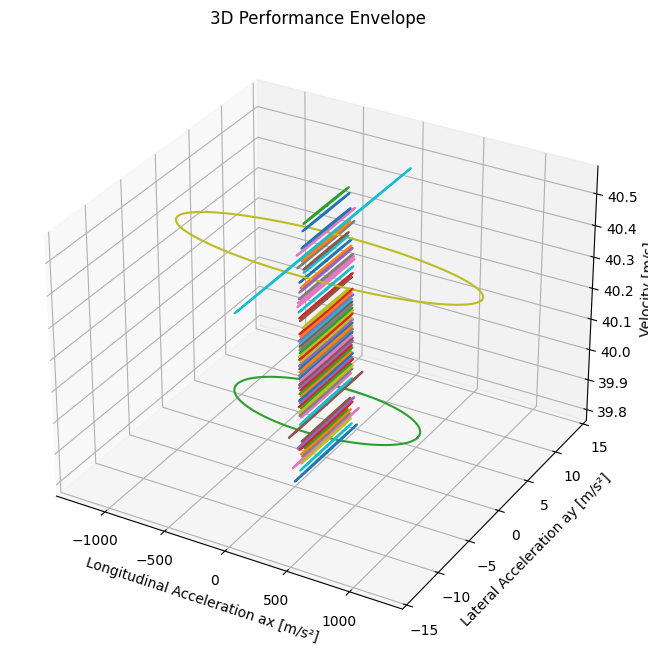

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


vehicle_mass = 341  # in kg

# Normalize the grip values to get acceleration
max_acc_lat = {v: grip / vehicle_mass for v, grip in max_grip_results.items()}
max_acc_long = {v: grip / vehicle_mass for v, grip in max_grip_results_long.items()}

# Intersect the keys (velocities) in both dictionaries
common_velocities = set(max_acc_lat).intersection(max_acc_long)

# Setup the figure and axes for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop over each common velocity and create an ellipse
for velocity in common_velocities:
    ax_max = max_acc_long[velocity]  # Longitudinal acceleration
    ay_max = max_acc_lat[velocity]   # Lateral acceleration

    # Ellipse parameters for the ax and ay accelerations
    theta = np.linspace(0, 2 * np.pi, 100)
    ax_ellipse = ax_max * np.cos(theta)
    ay_ellipse = ay_max * np.sin(theta)

    # Plot the ellipse for this velocity, centered at 0
    ax.plot(ax_ellipse, ay_ellipse, zs=velocity, zdir='z', label=f'Velocity = {velocity} m/s')

# Set labels and title
ax.set_xlabel('Longitudinal Acceleration ax [m/s²]')
ax.set_ylabel('Lateral Acceleration ay [m/s²]')
ax.set_zlabel('Velocity [m/s]')
ax.set_title('3D Performance Envelope')

# Show plot
plt.show()


In [19]:
df_lat = pd.DataFrame(list(max_acc_lat.items()), columns=['Velocity', 'MaxGripLat'])
df_long = pd.DataFrame(list(max_acc_long.items()), columns=['Velocity', 'MaxGripLong'])

# Merge the DataFrames on the 'Velocity' column
df_joined = pd.merge(df_lat, df_long, on='Velocity')

# Display the first few rows of the DataFrame
df_joined

,Velocity,MaxGripLat,MaxGripLong
0,39.78,5.012070,5.249112
1,39.80,4.144464,4.253717
2,39.82,3.983105,4.753499
3,39.83,5.316873,5.183976
4,39.84,3.832244,5.327546
...,...,...,...
56,40.47,13.641236,4.262460
57,40.49,4.540436,5.388553
58,40.50,3.813917,5.051064
59,40.55,3.647835,4.878731


{39.71: 4.876708679437646,
 39.72: 5.477311746549439,
 39.73: 4.471234103989669,
 39.75: 3.7382570533843857,
 39.76: 5.078137984100426,
 39.77: 5.373048175733047,
 39.78: 5.249111511041049,
 39.79: 5.222390813017584,
 39.8: 4.253716878175922,
 39.81: 5.4656513259339095,
 39.82: 4.7534992748742395,
 39.83: 5.183975670691312,
 39.84: 5.327546277976853,
 39.85: 4.121086892603566,
 39.86: 5.35224299242615,
 39.87: 4.671517146059674,
 39.88: 4.874385019113653,
 39.89: 4.5154256416947725,
 39.92: 752.0663040177409,
 39.94: 4.996817085970701,
 39.95: 5.034679199768125,
 39.97: 4.837501862671517,
 39.98: 5.0794970307865315,
 39.99: 4.785492115410006,
 40.0: 4.436280083809374,
 40.01: 4.63074305503229,
 40.02: 4.376849687914102,
 40.03: 4.152033385295942,
 40.04: 4.945068730642696,
 40.05: 4.1901683595379104,
 40.06: 3.857605957222331,
 40.07: 4.358883266226768,
 40.08: 4.921896502765912,
 40.09: 4.4770275964920225,
 40.1: 4.6185584637535495,
 40.11: 4.3649301736652975,
 40.12: 4.37795777675744